In [10]:
import sys
!{sys.executable} -m pip install lalsuite pycbc


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


**1st Assignment - Matching filters**

**Part 1**

In [11]:
import numpy as np
from pycbc import types 
from pycbc.waveform import get_fd_waveform
from pycbc.filter import matched_filter
from pycbc.conversions import mass1_from_mchirp_q
from pycbc.waveform import get_td_waveform
import pycbc.psd
from pycbc.psd import interpolate
# As an example we use the GW150914 data
from pycbc.catalog import Merger
from pycbc.filter import resample_to_delta_t, highpass



Problem 1: Load the data

In [12]:
!wget -nc https://dcc.ligo.org/public/0146/P1700349/001/H-H1_LOSC_CLN_4_V1-1187007040-2048.gwf
!wget -nc https://dcc.ligo.org/public/0146/P1700349/001/L-L1_LOSC_CLN_4_V1-1187007040-2048.gwf

File ‘H-H1_LOSC_CLN_4_V1-1187007040-2048.gwf’ already there; not retrieving.

File ‘L-L1_LOSC_CLN_4_V1-1187007040-2048.gwf’ already there; not retrieving.



**Part 2**

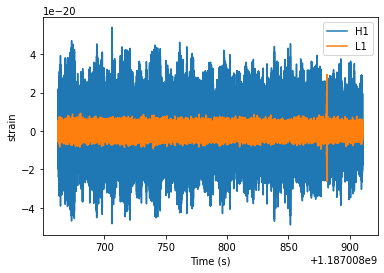

In [15]:
#Then run the following command to load the strain data. 
%matplotlib inline
import pylab
from pycbc.filter import highpass
from pycbc.catalog import Merger
from pycbc.frame import read_frame
from pycbc.filter import resample_to_delta_t, highpass

merger = Merger("GW170817")
strain, stilde = {}, {}
for ifo in ['H1', 'L1']:
   # We'll download the data and select 256 seconds that includes the event time
   ts = read_frame("{}-{}_LOSC_CLN_4_V1-1187007040-2048.gwf".format(ifo[0], ifo),
                   '{}:LOSC-STRAIN'.format(ifo),
                  start_time=merger.time - 224,
                  end_time=merger.time + 32,
                  check_integrity=False)
  
   # Read the detector data and remove low frequency content
   strain[ifo] = resample_to_delta_t(highpass(ts, 15.0), 1.0/2048)
 
   # Remove time corrupted by the high pass filter
   strain[ifo] = strain[ifo].crop(4, 4)
  
   # Also create a frequency domain version of the data
   stilde[ifo] = strain[ifo].to_frequencyseries()
 
 
#print (strain.delta_t)
pylab.plot(strain['H1'].sample_times, strain['H1'], label= 'H1')
pylab.plot(strain['L1'].sample_times, strain['L1'], label= 'L1')
pylab.legend()
pylab.xlabel('Time (s)')
pylab.ylabel('strain')
pylab.show()


In [17]:
#power spectral density
psds = {}
for ifo in ['L1', 'H1']:


    delta_t = strain[ifo].delta_t #sampling time
    seg_len = int(2 / delta_t) 
    seg_stride = int(seg_len / 2) #how much overlapping of the segments 
    psds[ifo]  = pycbc.psd.welch(strain[ifo],
                      seg_len=seg_len,
                      seg_stride=seg_stride)
    
    psds[ifo] = interpolate(psds[ifo], stilde[ifo].delta_f)

  

In [16]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


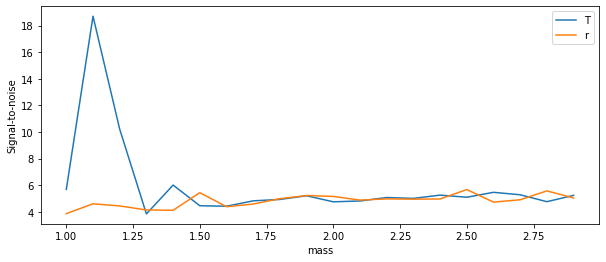

In [18]:
#creating gw waveform 

mass1 = np.arange(1, 3,0.10 ) #mass range bewteen 1 to 3 Solar mass-->100 points
mass2 = mass1 

# Variables to store when we've found the max
hmax, smax, tmax, mmax, nsnr = None, {}, {}, 0, 0
snrs = {}
#first detector
ifo = 'H1'
Snr_list = []
for i in range(len(mass1)):
    #Generate a waveform with a given component mass; assumed equal mass, nonspinning
 
    m = mass1[i] # Solar masses
    hp, hc = get_td_waveform(approximant="TaylorT2",
                     mass1=m,
                     mass2=m,
                     delta_t=strain[ifo].delta_t,
                     f_lower=15.0)

    # We will resize the vector to match our data
    hp.resize(len(strain[ifo]))
    template = hp.cyclic_time_shift(hp.start_time) #filter resizong it. data and template of the same length
    
    snr = matched_filter(template , strain[ifo],
                     psd=psds[ifo], low_frequency_cutoff=15.0) #template=K(t), data, powerspecrtal density(noise contribution), lower frequwncy cut

    snr_H1 = snr.crop(4 + 4, 4)


    Snr_list.append(max(abs(snr_H1)))
snrs[ifo] = Snr_list


#second detector
ifo = 'L1'
Snr_list = []
for i in range(len(mass1)):
    #Generate a waveform with a given component mass; assumed equal mass, nonspinning
 
    m = mass1[i] # Solar masses
    hp, hc = get_td_waveform(approximant="TaylorT2",
                     mass1=m,
                     mass2=m,
                     delta_t=strain[ifo].delta_t,
                     f_lower=15.0)

    # We will resize the vector to match our data
    hp.resize(len(strain[ifo]))
    template = hp.cyclic_time_shift(hp.start_time)
    
    snr = matched_filter(template, strain[ifo],
                     psd=psds[ifo], low_frequency_cutoff=15.0)

 
    snr_H1 = snr.crop(4 + 4, 4)


    Snr_list.append(max(abs(snr_H1)))
snrs[ifo] = Snr_list


pylab.figure(figsize=[10, 4])
pylab.plot(mass1, snrs['H1'], label= 'H1')
pylab.plot(mass1, snrs['L1'], label= 'L1')
pylab.legend('True')
pylab.ylabel('Signal-to-noise')
pylab.xlabel('mass')
pylab.show()


                                
                                

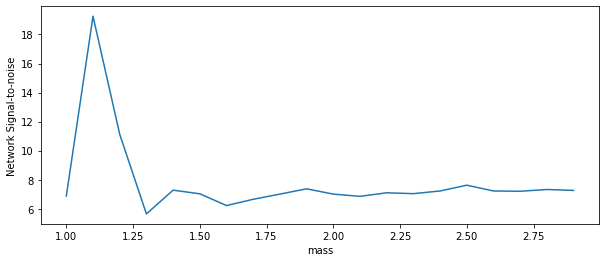

We found the best Mass1=Mass2 was 1.10 solar masses (detector frame)


In [19]:
#finding the mass at which the 
nsnr = (np.array(snrs['H1'])**2 + np.array(snrs['L1'])**2)**0.5
ii = np.where(nsnr == max(nsnr)) #find max mass where snr is max, match filtering
pylab.figure(figsize=[10, 4])
pylab.plot(mass1, nsnr)

pylab.ylabel('Network Signal-to-noise')
pylab.xlabel('mass')
pylab.show()

print("We found the best Mass1=Mass2 was %2.2f solar masses (detector frame)" % mass1[ii])

if the second detector has a signal under treshold 8 --> do we have to take into consideration that signal when doing the nsnr?

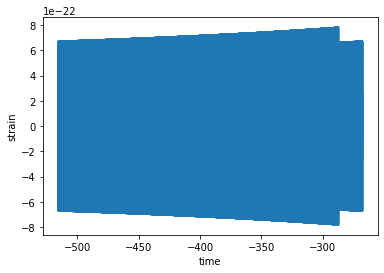

In [33]:
#recreating template using the mass that maximises our snr
m = 1.10 # Solar masses
conditioned = strain['H1']
hp, hc = get_td_waveform(approximant="TaylorT2",
                     mass1=m,
                     mass2=m,
                     delta_t=conditioned.delta_t,
                     f_lower=15)

# We will resize the vector to match our data
hp.resize(len(conditioned))

template = hp .cyclic_time_shift(hp.start_time)
pylab.plot(hp.sample_times, template)
pylab.xlabel('time')
pylab.ylabel('strain')
pylab.show()

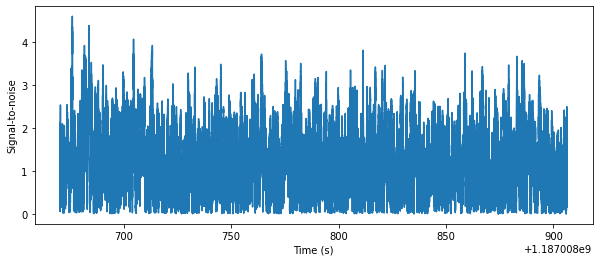

We found a signal at 1187008676.1626954s with SNR 4.598844273689113


In [34]:
#new fitting with new data
ifo = 'L1'                            
conditioned = strain[ifo]
snr = matched_filter(template, conditioned,
                     psd=psds[ifo] , low_frequency_cutoff=15)

snr = snr.crop(4 + 4, 4)

pylab.figure(figsize=[10, 4])
pylab.plot(snr.sample_times, abs(snr))
pylab.ylabel('Signal-to-noise')
pylab.xlabel('Time (s)')
pylab.show()

peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]

print("We found a signal at {}s with SNR {}".format(time, 
                                                    abs(snrp)))

In [25]:
from pycbc.filter import sigma

# Shift the template to the peak time
dt = time - conditioned.start_time
aligned = template.cyclic_time_shift(dt)

# scale the template so that it would have SNR 1 in this data
aligned /= sigma(aligned, psd=psds[ifo], low_frequency_cutoff=20.0)

# Scale the template amplitude and phase to the peak value
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries()
aligned.start_time = conditioned.start_time

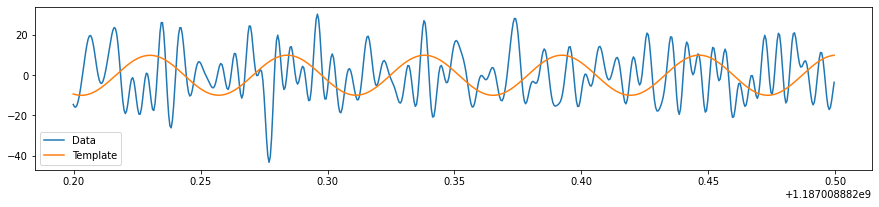

In [38]:
# We do it this way so that we can whiten both the template and the data
white_data = (conditioned.to_frequencyseries() / psds[ifo]**0.5).to_timeseries()

# apply a smoothing of the turnon of the template to avoid a transient
# from the sharp turn on in the waveform.
tapered = aligned.highpass_fir(15, 400, remove_corrupted=False)
white_template = (tapered.to_frequencyseries() / psds[ifo]**0.5).to_timeseries()

white_data = white_data.highpass_fir(15., 400).lowpass_fir(200, 400)
#white_template = white_template.highpass_fir(30, 512).lowpass_fir(300, 512)

# Select the time around the merger
white_data = white_data.time_slice(merger.time-.2, merger.time+.1)
white_template = white_template.time_slice(merger.time-.2, merger.time+.1)

pylab.figure(figsize=[15, 3])
pylab.plot(white_data.sample_times, white_data, label="Data")
pylab.plot(white_template.sample_times, white_template, label="Template")
pylab.legend()
pylab.show()

**Part 3**

In [55]:
from pycbc.waveform import get_td_waveform
from pycbc.filter import match
from pycbc.psd import aLIGOZeroDetHighPower 

f_low = 30
sample_rate = 4096
sp_all=[]
#generating two waveforms
hp, hc = get_td_waveform(approximant="TaylorT2",
                         mass1=10,
                         mass2=10,
                         f_lower=f_low,
                         delta_t=1.0/sample_rate)
mass_range = np.arange(5,15)
for i in mass_range:
  sp, sc = get_td_waveform(approximant="TaylorT2",
                          mass1=i,
                          mass2=i,
                          f_lower=f_low,
                          delta_t=1.0/sample_rate)
  sp_all.append(sp)
  
  


#resizing waveform to same length
tlen = max(len(sp), len(hp))
for sp in sp_all:
  sp.resize(tlen)
hp.resize(tlen)
m_all=[]
for sp in sp_all:
  


 


In [ ]:
#Problem 2
#first download the data from the assignament 

'''
Loading the data and converting the data type into time series
'''
d = np.load('/content/drive/MyDrive/noise_ts_4096Hz.npy') #name of the data file noise_ts_4096Hz.npy
dt = d[:, 0]
d = types.TimeSeries(d[:, 1], delta_t = dt[1]- dt[0]) #this is to comvert data into GW timeSeries
data = d